In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

In [2]:
import os

In [3]:
os.getcwd()

'/root/Arghya_scripts/Alenza/Alenza_nlp'

In [4]:
con_bhv_df = pd.read_csv('Customer_behaviour_analysis.csv')

In [5]:
con_bhv_df.shape

(603, 3)

In [6]:
con_bhv_df.head(10)

,topic,word,lifecycle
0,Amenities,air con,stay
1,Amenities,air conditioner,stay
2,Amenities,air conditioner,before arrival
3,Amenities,air conditioning,stay
4,Amenities,airport shuttle,before arrival
5,Amenities,airport shuttle,stay
6,Amenities,balcony,stay
7,Amenities,bar,stay
8,Amenities,barbeque,stay
9,Amenities,bars,stay


In [7]:
import copy

In [8]:
## check if we indeed have three topics
con_bhv_df.topic.value_counts().index

Index(['Experience', 'Amenities', 'experience', 'Location', 'Value',
       'Transactions', 'value', 'location', 'transactions', 'amenities'],
      dtype='object')

In [9]:
#making topic classes case uniform
#converting small case to caps
con_bhv_df['topic'] = con_bhv_df['topic'].replace({'value': 'Value', 'transactions': 'Transactions', 'location': 'Location', 'experience': 'Experience','amenities': 'Amenities'})



In [10]:
#recheck
## check if we indeed have three topics
con_bhv_df.topic.value_counts().index

Index(['Experience', 'Value', 'Location', 'Amenities', 'Transactions'], dtype='object')

In [12]:
input_df_oaks_rev = copy.deepcopy(con_bhv_df)

In [13]:

con_bhv_df.loc[(con_bhv_df['topic'] == "Experience") & (con_bhv_df['word'] == "air") & (con_bhv_df['lifecycle'] == "check-in")]

,topic,word,lifecycle
546,Experience,air,check-in


In [8]:
#function to shuffle the dagtaframe

In [14]:
input_df_oaks_rev_shuffled = input_df_oaks_rev.iloc[np.random.permutation(len(input_df_oaks_rev))]

In [15]:
input_df_oaks_rev_shuffled.head(10)

,topic,word,lifecycle
220,Transactions,front desk,check-in
584,Transactions,early,before arrival
583,Transactions,early,check-in
155,Location,easy walking,stay
120,Experience,love,check-out
497,Transactions,available,before arrival
158,Location,good location,stay
269,Location,great location,before arrival
287,Value,apartment,before arrival
427,Experience,would stay,check-out


In [30]:
#spilt the dataset into train and test dataframes(sets)

In [16]:
from sklearn.model_selection import train_test_split

oaks_rev_train_df,oaks_rev_test_df = train_test_split(input_df_oaks_rev_shuffled, test_size=0.2)

In [17]:
oaks_rev_train_df.shape

(482, 3)

In [18]:
oaks_rev_test_df.shape

(121, 3)

In [ ]:
#feature inspection(exploring the data)

In [19]:
# check if there's missing data
oaks_rev_train_df.isnull().sum()

topic        0
word         0
lifecycle    0
dtype: int64

In [20]:
# check if we indeed have five topics
oaks_rev_train_df.topic.value_counts().index

Index(['Experience', 'Value', 'Amenities', 'Location', 'Transactions'], dtype='object')

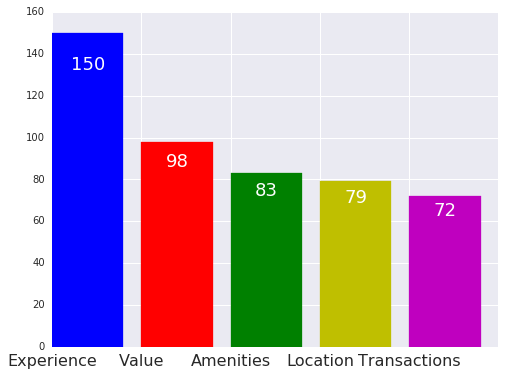

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

topic_vc = oaks_rev_train_df.topic.value_counts()

ax.bar(range(5), topic_vc)
ax.set_xticks(range(5))
ax.set_xticklabels(topic_vc.index, fontsize=16)

for rect, c, value in zip(ax.patches, ['b', 'r', 'g','y','m'], topic_vc.values):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')

In [56]:
#pitfalls
#chance of biasedness due to huge diff b2n Experience and Transactions

In [22]:
#inspecting the text variables
document_lengths = np.array(list(map(len, oaks_rev_train_df.word.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 1.8526970954356847.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 4.


In [58]:
# see the distribution of the number of words in a document.

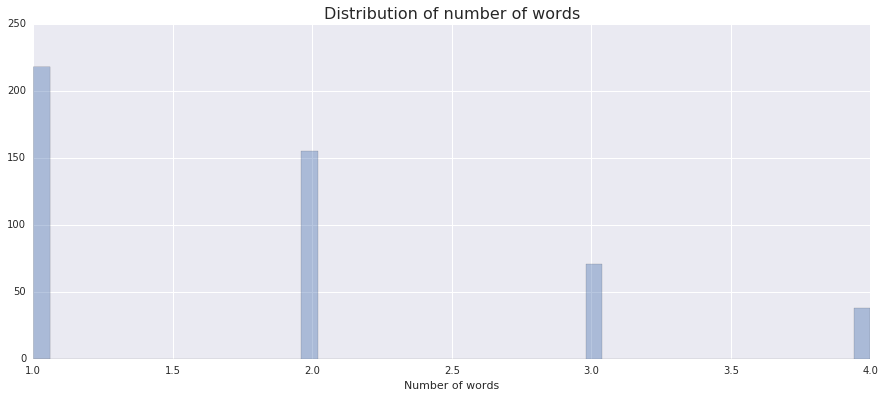

In [23]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax,kde=False);

In [24]:
print("There are {} documents with over 1 words.".format(sum(document_lengths > 1)))

shorter_documents = document_lengths[document_lengths <= 1]

There are 264 documents with over 1 words.


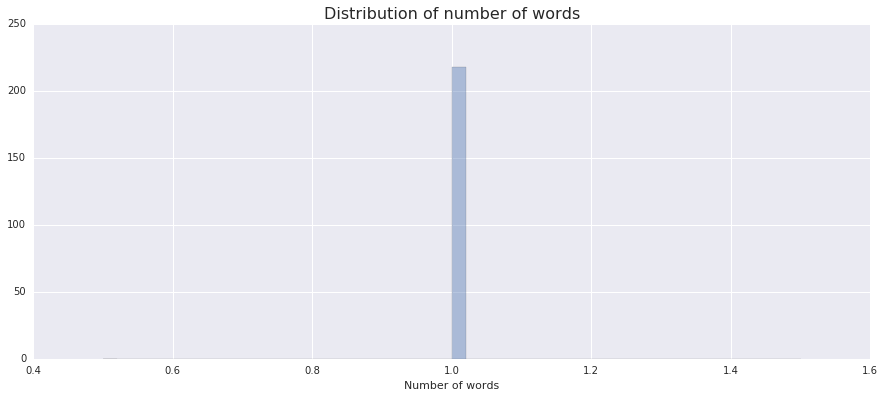

In [25]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax,kde = False);

In [26]:
oaks_rev_train_df[document_lengths == 1]

,topic,word,lifecycle
69,Amenities,towels,stay
195,Transactions,book,check-in
44,Amenities,nights,stay
87,Experience,awesome,check-out
306,Value,clean,after departure
353,Experience,everything,check-out
177,Location,shopping,stay
252,Value,modern,before arrival
179,Location,shops,stay
202,Transactions,checked,check-in


In [27]:
oaks_rev_train_df[document_lengths == 2]

,topic,word,lifecycle
221,Transactions,front desk,check-out
100,Experience,good room,check-out
190,Location,walking distance,before arrival
135,Experience,staff excellent,stay
167,Location,location Walk,stay
254,Value,modern facilities,after departure
557,Experience,bathroom not,check-out
80,Experience,apartment comfortable,stay
52,Amenities,pool spa,stay
459,Experience,room nice,check-out


In [28]:
oaks_rev_train_df[document_lengths == 3]

,topic,word,lifecycle
304,Value,room clean comfortable,after departure
520,Experience,no room service,check-in
401,Experience,not play golf,stay
286,Experience,great great staff,check-out
344,Experience,beds single beds,check-in
339,Experience,air cons power,stay
526,Experience,hotel staff friendly,stay
329,Transactions,front desk staff,check-out
288,Value,good value money,after departure
361,Experience,everything great home,stay


In [29]:
oaks_rev_train_df[document_lengths == 4]

,topic,word,lifecycle
418,Transactions,weeks ago paid night,before arrival
457,Experience,staff friendly room clean,after departure
340,Value,apartment two room apartment,before arrival
341,Experience,assistance tv not not,stay
384,Experience,no exhaust fan bathroom,stay
332,Experience,air conditioner not work,stay
343,Value,bed provided comfortable spacious,after departure
420,Experience,rooms clean staff helpful,check-out
376,Experience,living area second bedroom,check-in
400,Experience,room comfortable good facilities,check-out


In [30]:
oaks_rev_train_df[document_lengths == 5]

,topic,word,lifecycle


In [ ]:
#feature_creation

In [ ]:
# preprocessing steps for LDA

In [31]:
def lda_get_good_tokens(df):
    df['word'] = df.word.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.word))
    

lda_get_good_tokens(oaks_rev_train_df)

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [ ]:
# Let's view at the top word frequencies now and get an idea of the words that are used mostly.

In [32]:
tokenized_only_dict = Counter(np.concatenate(oaks_rev_train_df.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [33]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

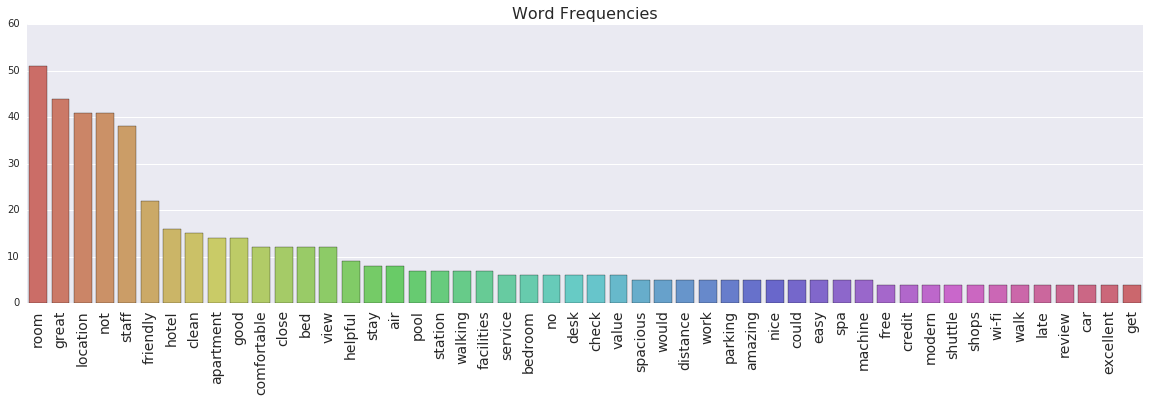

In [34]:
#function for word frequency 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

In [ ]:
#stemming with lemmatization, this will stem words like leaves to leaf. 
#we'll apply  porterstemmer which in turn will complete the stemming by converting words like running to run.

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
 from nltk.corpus import wordnet as wn

In [37]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df.tokenized_text))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda word:
                                  list(map(p_stemmer.stem, word)),
                                  df.lemmatized_text))

stem_words(oaks_rev_train_df)

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
# creating a dictionary for the model. Since a computer can't reallly understand what a word means, we need to transform it into some number the model will be able to work with. 
# using gensim.corpora.Dictionary for this.

In [38]:
dictionary = Dictionary(documents=oaks_rev_train_df.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 265 words.


In [39]:
dictionary.filter_extremes(no_above=0.8, no_below=2)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 130 words.


In [ ]:
# I decided to remove only the top 20% of words since we're dealing with a relatively small dataset here. Also words that occur less than 2 times are removed.

In [40]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(oaks_rev_train_df)

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [41]:
# we make a function for lda_preprocessing
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    stem_words(df)
    document_to_bow(df)

In [43]:
#VISUALISE THE cleaned word frequencies

In [ ]:
# before using LDA and Word2Vec,would like to visualize the cleansed results and see what was created so far

In [42]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [43]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)


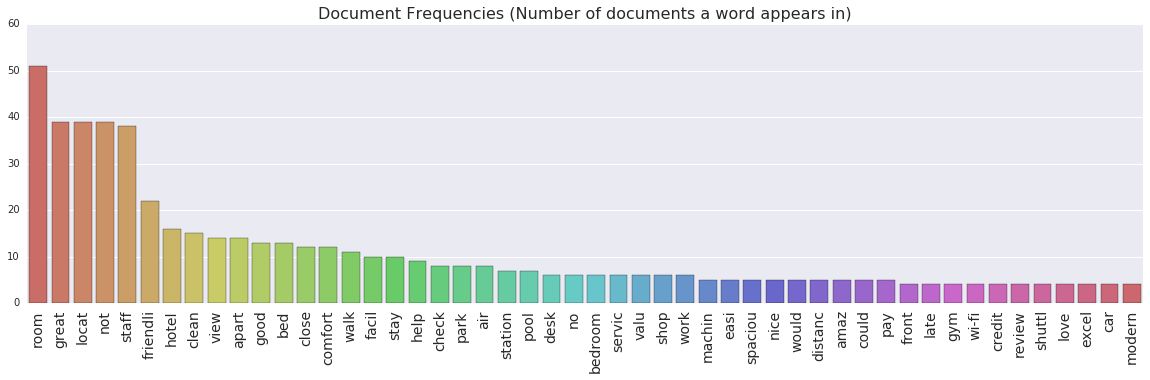

In [44]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [ ]:
# see how often each of the topics used these words in the plot above and see if we can find something interesting.

In [45]:
Experience_words = list(np.concatenate(oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Experience', 'stemmed_text'].values))
Value_words = list(np.concatenate(oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Value', 'stemmed_text'].values))
Location_words = list(np.concatenate(oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Location', 'stemmed_text'].values))
Amenities_words = list(np.concatenate(oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Amenities', 'stemmed_text'].values))
Transactions_words = list(np.concatenate(oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Transactions', 'stemmed_text'].values))

In [ ]:
'Experience', 'Value', 'Location', 'Amenities', 'Transactions'

In [46]:
Experience_words_frequencies = {word: Experience_words.count(word) for word in cleansed_words_df.index[:50]}
Value_words_frequencies = {word: Value_words.count(word) for word in cleansed_words_df.index[:50]}
Location_words_frequencies = {word: Location_words.count(word) for word in cleansed_words_df.index[:50]}
Amenities_words_frequencies = {word: Amenities_words.count(word) for word in cleansed_words_df.index[:50]}
Transactions_words_frequencies = {word: Transactions_words.count(word) for word in cleansed_words_df.index[:50]}

In [47]:
frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

In [48]:
frequencies_df['Experience_freq'] = list(map(lambda word:
                                      Experience_words_frequencies[word],
                                      frequencies_df.index))
frequencies_df['Experience_Value_freq'] = list(map(lambda word:
                                          Experience_words_frequencies[word] + Value_words_frequencies[word],
                                          frequencies_df.index))
frequencies_df['Experience_Value_Location_freq'] = list(map(lambda word:
                                                   Experience_words_frequencies[word] + Value_words_frequencies[word] + Location_words_frequencies[word],
                                                   frequencies_df.index))
frequencies_df['Experience_Value_Location_Amenities_freq'] = list(map(lambda word:
                                                              Experience_words_frequencies[word] + Value_words_frequencies[word] + Location_words_frequencies[word]+Amenities_words_frequencies[word],
                                                              frequencies_df.index))
frequencies_df['Experience_Value_Location_Amenities_Transactions_freq'] = list(map(lambda word:
                                                                          Experience_words_frequencies[word] + Value_words_frequencies[word] + Location_words_frequencies[word]+Amenities_words_frequencies[word]+Transactions_words_frequencies[word],
                                                                          frequencies_df.index))                                            


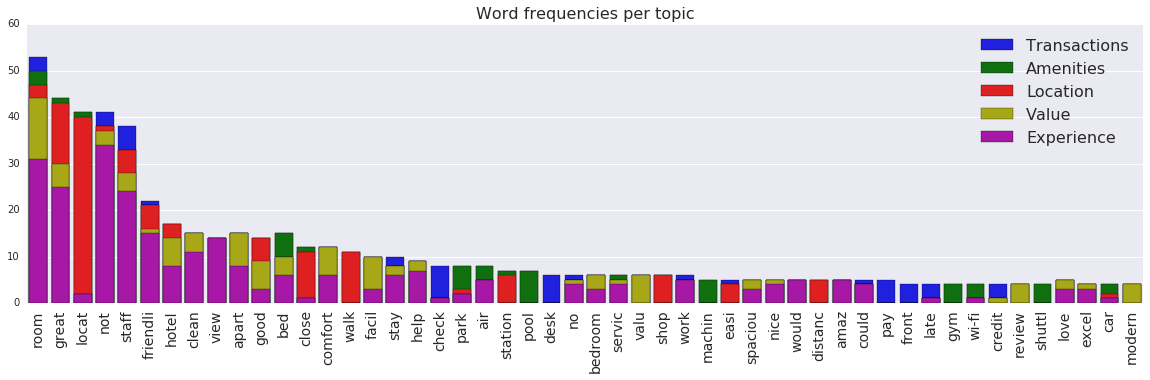

In [49]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['Experience_Value_Location_Amenities_Transactions_freq'].values, color='b', ax=ax, label="Transactions")
sns.barplot(nrs, frequencies_df['Experience_Value_Location_Amenities_freq'].values, color='g', ax=ax, label="Amenities")
sns.barplot(nrs, frequencies_df['Experience_Value_Location_freq'].values, color='r', ax=ax, label="Location")
sns.barplot(nrs, frequencies_df['Experience_Value_freq'].values, color='y', ax=ax, label="Value")
sns.barplot(nrs, frequencies_df['Experience_freq'].values, color='m', ax=ax, label="Experience")

ax.set_title("Word frequencies per topic", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

In [ ]:
#LDA training

In [50]:
corpus = oaks_rev_train_df.bow

In [51]:
%%time
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 8.97 s, sys: 1.77 s, total: 10.7 s
Wall time: 10.6 s


In [ ]:
# LDA topic inspection

In [52]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

oaks_rev_train_df['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      oaks_rev_train_df.bow))

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# Now let's continue with the topic's individual topic distributions and let's see some words that come with the topics

In [ ]:
# Experience_Value_Location_Amenities_Transactions

In [53]:
Experience_topic_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Experience', 'lda_features'].mean()
Value_topic_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Value', 'lda_features'].mean()
Location_topic_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Location', 'lda_features'].mean()
Amenities_topic_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Amenities', 'lda_features'].mean()
Transactions_topic_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Transactions', 'lda_features'].mean()

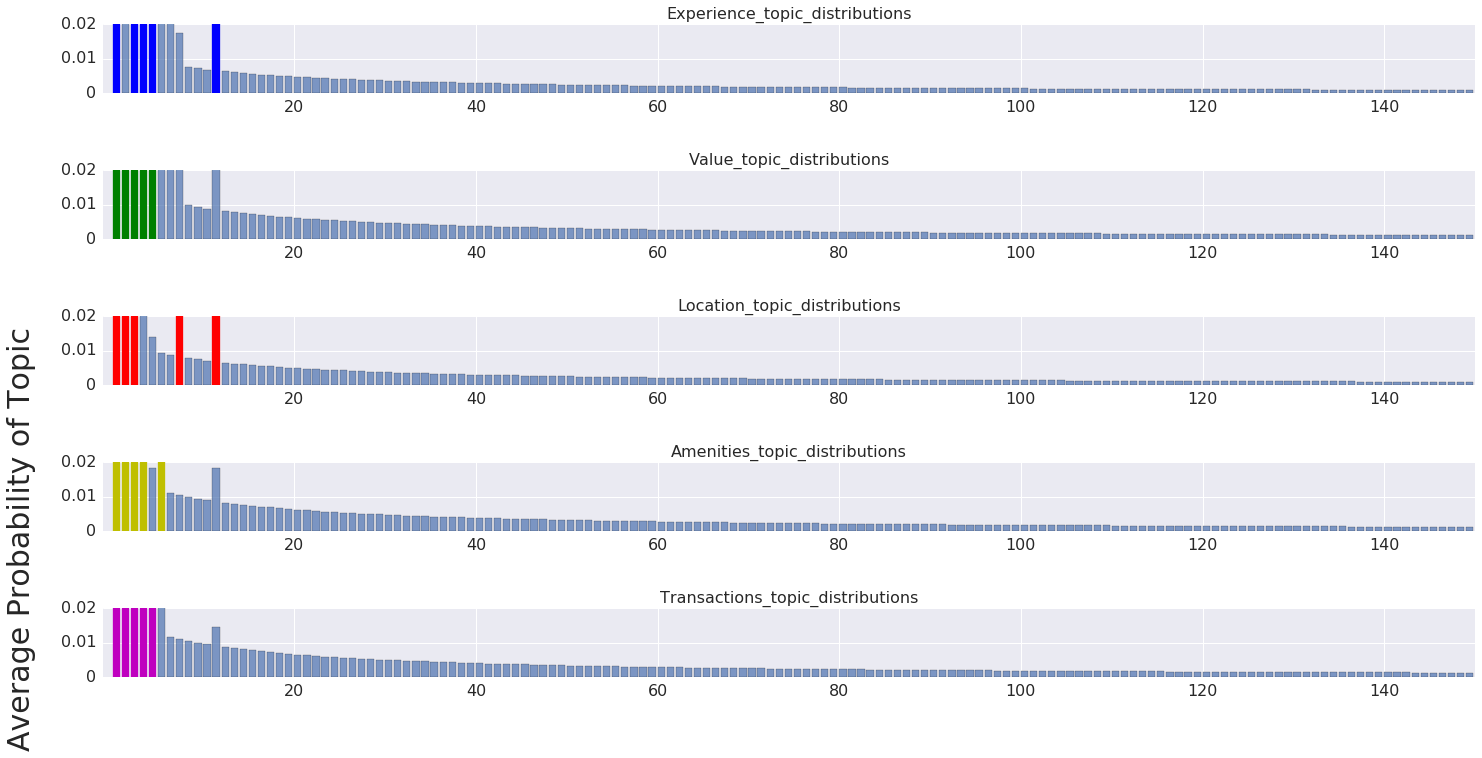

In [54]:
fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(5,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("Experience_topic_distributions", fontsize=16)
ax2.set_title("Value_topic_distributions", fontsize=16)
ax3.set_title("Location_topic_distributions", fontsize=16)
ax4.set_title("Amenities_topic_distributions", fontsize=16)
ax5.set_title("Transactions_topic_distributions", fontsize=16)
ax5.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3,ax4,ax5],
                                   [Experience_topic_distribution,Value_topic_distribution,Location_topic_distribution,Amenities_topic_distribution,Transactions_topic_distribution],
                                   ['b','g','r','y','m']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,20))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=3.)

In [ ]:
# Let's have a look at what words these top topics contain.

In [55]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [56]:
for topic, distribution in zip(['Experience','Value','Location','Amenities','Transactions'], [Experience_topic_distribution,Value_topic_distribution,Location_topic_distribution,Amenities_topic_distribution,Transactions_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(topic))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from Experience.
For topic 0, the top words are: view, walk, facil, check, shop.
For topic 2, the top words are: room, staff, help, desk, servic.
For topic 3, the top words are: hotel, bed, clean, comfort, not.
For topic 4, the top words are: not, valu, work, money, night.
For topic 11, the top words are: great, staff, locat, friendli, close.

Looking up top words from top topics from Value.
For topic 0, the top words are: view, walk, facil, check, shop.
For topic 1, the top words are: not, park, air, pay, spa.
For topic 2, the top words are: room, staff, help, desk, servic.
For topic 3, the top words are: hotel, bed, clean, comfort, not.
For topic 4, the top words are: not, valu, work, money, night.

Looking up top words from top topics from Location.
For topic 0, the top words are: view, walk, facil, check, shop.
For topic 1, the top words are: not, park, air, pay, spa.
For topic 2, the top words are: room, staff, help, desk, servic.
For topic 7, 

In [57]:
def show_image(base64_encoded_image):
    """ Decodes a base64 encoded image and plots it.
    """
    fig, ax = plt.subplots(figsize=(10,10))

    decoded_image = base64.b64decode(base64_encoded_image)
    img = io.BytesIO(decoded_image)
    img = mpimg.imread(img, format='PNG')

    ax.imshow(img)
    ax.axis('off');

In [ ]:
# Word2Vec training

In [58]:
oaks_rev_train_df.dtypes

topic              object
word               object
lifecycle          object
tokenized_text     object
lemmatized_text    object
stemmed_text       object
bow                object
lda_features       object
dtype: object

In [59]:
oaks_rev_train_df["tokenized_sentences"] = oaks_rev_train_df["word"]

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [60]:
oaks_rev_train_df["tokenized_sentences"].head(10)

69                     towels
195                      book
44                     nights
304    room clean comfortable
87                    awesome
221                front desk
100                 good room
306                     clean
190          walking distance
353                everything
Name: tokenized_sentences, dtype: object

In [61]:
oaks_rev_train_df["tokenized_sentences"].shape

(482,)

In [62]:
oaks_rev_train_df.tokenized_sentences

69                        towels
195                         book
44                        nights
304       room clean comfortable
87                       awesome
221                   front desk
100                    good room
306                        clean
190             walking distance
353                   everything
418         weeks ago paid night
177                     shopping
520              no room service
252                       modern
179                        shops
202                      checked
457    staff friendly room clean
135              staff excellent
167                location walk
94                       concern
314                        close
254            modern facilities
557                 bathroom not
530                         look
401                not play golf
80         apartment comfortable
286            great great staff
344             beds single beds
52                      pool spa
459                    room nice
          

In [63]:
sentences = []
for sentence_group in oaks_rev_train_df.tokenized_sentences:
    sentences.append(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(oaks_rev_train_df)))
print(sentences)

Number of sentences: 482.
Number of texts: 482.
['towels', 'book', 'nights', 'room clean comfortable', 'awesome', 'front desk', 'good room', 'clean', 'walking distance', 'everything', 'weeks ago paid night', 'shopping', 'no room service', 'modern', 'shops', 'checked', 'staff friendly room clean', 'staff excellent', 'location walk', 'concern', 'close', 'modern facilities', 'bathroom not', 'look', 'not play golf', 'apartment comfortable', 'great great staff', 'beds single beds', 'pool spa', 'room nice', 'car parking', 'public transport', 'great location', 'nearby', 'casino', 'overall', 'location close', 'excellent', 'nice view', 'air cons power', 'apartment two room apartment', 'sofa bed', 'luxury', 'hotel', 'hotel staff friendly', 'overcharged', 'assistance tv not not', 'location friendly', 'apartment spacious', 'clean room', 'friendly staff', 'priced', 'pool gym', 'not location', 'bed not', 'front desk staff', 'great room', 'hotels', 'experience', 'no exhaust fan bathroom', 'minibar', 

In [64]:
%%time
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 102 ms, sys: 23.5 ms, total: 126 ms
Wall time: 115 ms


In [65]:
sentence_group

'arrival'

In [64]:
#create the word2vec features.

In [66]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.hstack(sentence_group)  # words in word
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

oaks_rev_train_df['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      oaks_rev_train_df.tokenized_sentences))

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
Experience_w2v_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Experience', 'w2v_features'].mean()
Value_w2v_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Value', 'w2v_features'].mean()
Location_w2v_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Location', 'w2v_features'].mean()
Amenities_w2v_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Amenities', 'w2v_features'].mean()
Transactions_w2v_distribution = oaks_rev_train_df.loc[oaks_rev_train_df.topic == 'Transactions', 'w2v_features'].mean()

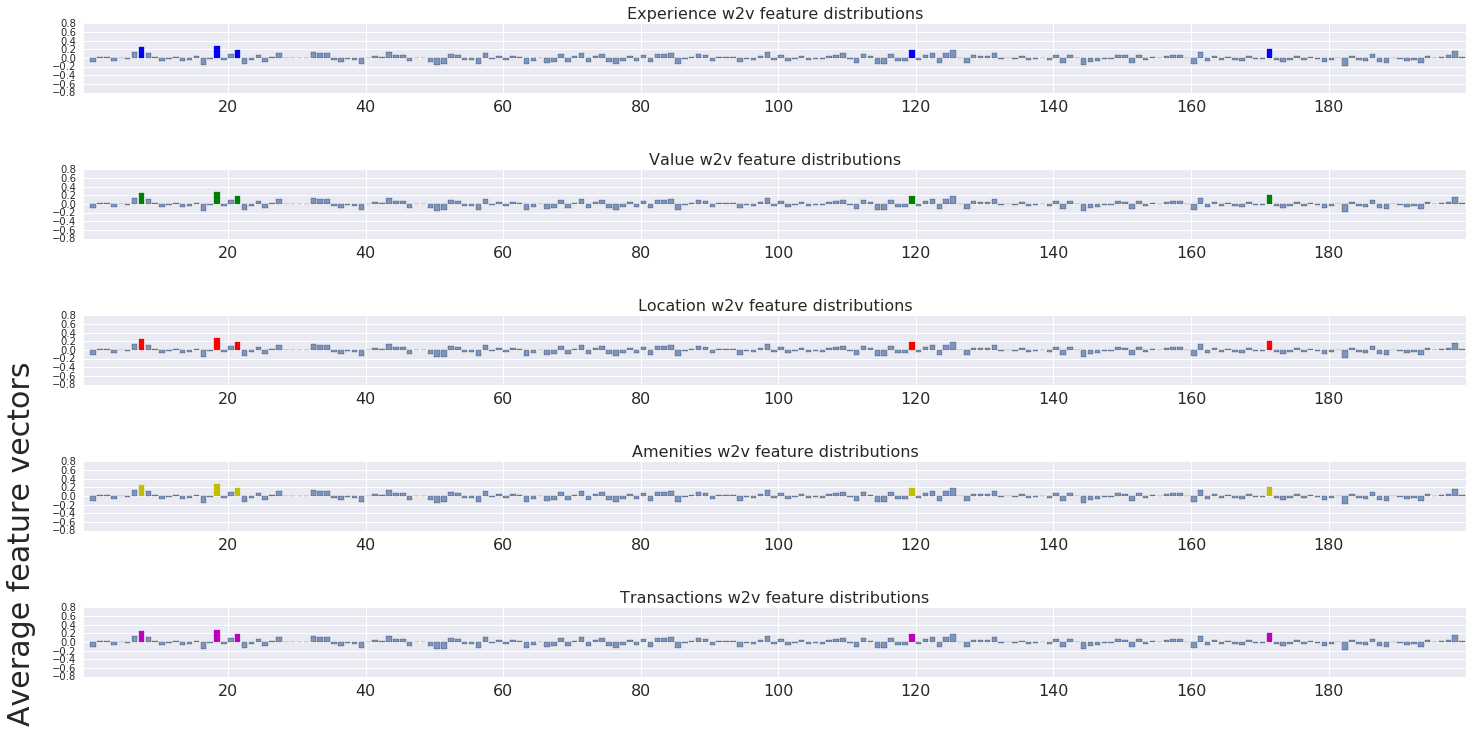

In [68]:
fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(5,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("Experience w2v feature distributions", fontsize=16)
ax2.set_title("Value w2v feature distributions", fontsize=16)
ax3.set_title("Location w2v feature distributions", fontsize=16)
ax4.set_title("Amenities w2v feature distributions", fontsize=16)
ax5.set_title("Transactions w2v feature distributions", fontsize=16)
ax5.text(-10, 2.3, "Average feature vectors", fontsize=30, ha="center", va="center", rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3,ax4,ax5], [Experience_w2v_distribution,Value_w2v_distribution,Location_w2v_distribution,Amenities_w2v_distribution,Transactions_w2v_distribution], ['b','g','r','y','m']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 200)
    ax.set_xticks(range(20,199,20))
    ax.set_xticklabels(range(20,199,20), fontsize=16)
    ax.set_ylim(-0.8,0.8)

fig.tight_layout(h_pad=3.)

In [ ]:
#classification and hyperparameter tuning

In [69]:
label_encoder = LabelEncoder()

label_encoder.fit(oaks_rev_train_df.topic)
oaks_rev_train_df['topic_id'] = label_encoder.transform(oaks_rev_train_df.topic)

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [71]:
#  since oaks_rev_train_df['lda_features'] and oaks_rev_train_df['w2v_features'] don't have the needed shape and type yet,
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, oaks_rev_train_df.lda_features)))
X_train_w2v = np.array(list(map(np.array, oaks_rev_train_df.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [ ]:
# since we are dealing with log loss and not simply accuracy, we have to choose models that support the method predict_proba.


In [72]:
# store all models in a dictionary
models = dict()

In [73]:
# Logistic Regression
# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, oaks_rev_train_df.topic_id)

models['best_lr_lda'] = best_lr_lda


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.427561,-1.381167,1,l1
1,-1.439484,-1.398597,2,l2


In [74]:
# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v,oaks_rev_train_df.topic_id)

models['best_lr_w2v'] = best_lr_w2v

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,-1.570181,-1.570030,1,l2
0,-1.570572,-1.570485,2,l1


In [75]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined,oaks_rev_train_df.topic_id)

models['best_lr_combined'] = best_lr_combined

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.427586,-1.381154,1,l1
1,-1.439006,-1.397694,2,l2


In [ ]:
#combining the two features gives us the optimal performance

In [ ]:
# Model Selection

In [76]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_w2v has a test score of: -1.5702
Model best_lr_combined has a test score of: -1.4276
Model best_lr_lda has a test score of: -1.4276


In [ ]:
#will go with best_lr_combined

In [77]:
oaks_rev_test_df.head(10)

,topic,word,lifecycle
330,Experience,great location great staff,check-out
255,Value,money,before arrival
411,Transactions,stored luggage check,check-in
38,Amenities,meal,stay
26,Amenities,fridge,stay
413,Value,rain forest,before arrival
494,Transactions,high,check-in
586,Amenities,bath,before arrival
489,Value,floor,before arrival
285,Experience,friendly helpful staff,check-out


In [78]:
oaks_rev_test_df['index_id'] = oaks_rev_test_df.index

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [80]:
test_data = copy.deepcopy(oaks_rev_test_df)

In [ ]:
test

In [81]:
test_data.drop("topic",axis = 1,inplace = True)

In [82]:
lda_preprocessing(test_data)

In [83]:
test_data["tokenized_sentences"] = test_data["word"]

In [84]:
test_data['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     test_data.bow))

test_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     test_data.tokenized_sentences))

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [85]:
oaks_rev_train_df['topic_id'] = label_encoder.transform(oaks_rev_train_df.topic)

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [86]:
X_test_lda = np.array(list(map(np.array, test_data.lda_features)))
X_test_w2v = np.array(list(map(np.array, test_data.w2v_features)))
X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

In [ ]:
#  classifications.

In [87]:
predictions = best_lr_combined.predict_proba(X_test_combined)

In [88]:
label_encoder.classes_

array(['Amenities', 'Experience', 'Location', 'Transactions', 'Value'],
      dtype=object)

In [120]:
test_data.head(10)

,word,lifecycle,index_id,tokenized_text,lemmatized_text,stemmed_text,bow,tokenized_sentences,lda_features,w2v_features
330,great location great staff,check-out,330,"[great, location, great, staff]","[great, location, great, staff]","[great, locat, great, staff]","[(18, 1), (20, 1), (27, 2)]",great location great staff,"[0.006227807141840458, 0.005757693201303482, 0...","[-0.103962064, 0.01369077, 0.013909781, -0.073..."
255,money,before arrival,255,[money],[money],[money],"[(48, 1)]",money,"[0.015569516457617283, 0.01439423207193613, 0....","[-0.10229806, 0.013378441, 0.013437969, -0.072..."
411,stored luggage check,check-in,411,"[stored, luggage, check]","[stored, luggage, check]","[store, luggag, check]","[(16, 1)]",stored luggage check,"[0.5155695080757141, 0.01439423207193613, 0.01...","[-0.1031294, 0.013868379, 0.01387767, -0.07311..."
38,meal,stay,38,[meal],[meal],[meal],[],meal,"[0.031139032915234566, 0.02878846414387226, 0....","[-0.10382951, 0.014088989, 0.01355009, -0.0740..."
26,fridge,stay,26,[fridge],[fridge],[fridg],[],fridge,"[0.031139032915234566, 0.02878846414387226, 0....","[-0.104707144, 0.013857122, 0.014062985, -0.07..."
413,rain forest,before arrival,413,"[rain, forest]","[rain, forest]","[rain, forest]",[],rain forest,"[0.031139032915234566, 0.02878846414387226, 0....","[-0.103889756, 0.013562163, 0.014001176, -0.07..."
494,high,check-in,494,[high],[high],[high],[],high,"[0.031139032915234566, 0.02878846414387226, 0....","[-0.101901725, 0.013574029, 0.014807995, -0.07..."
586,bath,before arrival,586,[bath],[bath],[bath],[],bath,"[0.031139032915234566, 0.02878846414387226, 0....","[-0.101424806, 0.013867817, 0.014103061, -0.07..."
489,floor,before arrival,489,[floor],[floor],[floor],[],floor,"[0.031139032915234566, 0.02878846414387226, 0....","[-0.10327866, 0.013507689, 0.014624566, -0.072..."
285,friendly helpful staff,check-out,285,"[friendly, helpful, staff]","[friendly, helpful, staff]","[friendli, help, staff]","[(17, 1), (18, 1), (68, 1)]",friendly helpful staff,"[0.0077847582288086414, 0.007197116035968065, ...","[-0.10335417, 0.013556015, 0.013442179, -0.073..."


In [121]:
result = np.append(test_data.index_id.values.reshape(-1,1),predictions, axis=1)

In [122]:
test_result_df = pd.DataFrame(data=result, columns=['index_id','Amenities', 'Experience', 'Location', 'Transactions', 'Value'])

In [123]:
test_result_df.head(10)

,index_id,Amenities,Experience,Location,Transactions,Value
0,330.0,0.024851,0.369218,0.544293,0.016675,0.044963
1,255.0,0.075364,0.499046,0.046608,0.157959,0.221022
2,411.0,0.252506,0.233330,0.164592,0.183917,0.165656
3,38.0,0.189440,0.279542,0.092132,0.180779,0.258107
4,26.0,0.189440,0.279542,0.092132,0.180779,0.258107
5,413.0,0.189440,0.279542,0.092132,0.180779,0.258107
6,494.0,0.189440,0.279542,0.092132,0.180779,0.258107
7,586.0,0.189440,0.279542,0.092132,0.180779,0.258107
8,489.0,0.189440,0.279542,0.092132,0.180779,0.258107
9,285.0,0.064135,0.483554,0.220091,0.084013,0.148207


In [125]:
test_result_df['index_id'] = test_result_df['index_id'].astype(np.int64)

In [140]:
test_result_df.head(10)

,index_id,Amenities,Experience,Location,Transactions,Value
0,330,0.024851,0.369218,0.544293,0.016675,0.044963
1,255,0.075364,0.499046,0.046608,0.157959,0.221022
2,411,0.252506,0.233330,0.164592,0.183917,0.165656
3,38,0.189440,0.279542,0.092132,0.180779,0.258107
4,26,0.189440,0.279542,0.092132,0.180779,0.258107
5,413,0.189440,0.279542,0.092132,0.180779,0.258107
6,494,0.189440,0.279542,0.092132,0.180779,0.258107
7,586,0.189440,0.279542,0.092132,0.180779,0.258107
8,489,0.189440,0.279542,0.092132,0.180779,0.258107
9,285,0.064135,0.483554,0.220091,0.084013,0.148207


In [141]:
test_result_df_sorted = test_result_df.sort_values("index_id")

In [142]:
test_result_df_sorted.head(10)

,index_id,Amenities,Experience,Location,Transactions,Value
36,3,0.323092,0.245154,0.076895,0.179937,0.174923
108,4,0.300156,0.232932,0.125535,0.183135,0.158242
85,6,0.189440,0.279542,0.092132,0.180779,0.258107
65,10,0.287789,0.255142,0.081021,0.181416,0.194632
109,11,0.189440,0.279542,0.092132,0.180779,0.258107
77,12,0.189440,0.279542,0.092132,0.180779,0.258107
4,26,0.189440,0.279542,0.092132,0.180779,0.258107
67,29,0.270802,0.215293,0.193337,0.181470,0.139098
3,38,0.189440,0.279542,0.092132,0.180779,0.258107
104,55,0.189440,0.279542,0.092132,0.180779,0.258107


In [146]:
test_result_df_sorted = test_result_df_sorted.reset_index(drop=True)

In [147]:
test_result_df_sorted.head(10)

,index_id,Amenities,Experience,Location,Transactions,Value
0,3,0.323092,0.245154,0.076895,0.179937,0.174923
1,4,0.300156,0.232932,0.125535,0.183135,0.158242
2,6,0.189440,0.279542,0.092132,0.180779,0.258107
3,10,0.287789,0.255142,0.081021,0.181416,0.194632
4,11,0.189440,0.279542,0.092132,0.180779,0.258107
5,12,0.189440,0.279542,0.092132,0.180779,0.258107
6,26,0.189440,0.279542,0.092132,0.180779,0.258107
7,29,0.270802,0.215293,0.193337,0.181470,0.139098
8,38,0.189440,0.279542,0.092132,0.180779,0.258107
9,55,0.189440,0.279542,0.092132,0.180779,0.258107


In [143]:
oaks_rev_test_df_sort

,topic,word,lifecycle
3,Amenities,air conditioning,stay
4,Amenities,airport shuttle,before arrival
6,Amenities,balcony,stay
10,Amenities,bathroom,stay
11,Amenities,breakfast,stay
12,Amenities,breakfast,before arrival
26,Amenities,fridge,stay
29,Amenities,free wifi,before arrival
38,Amenities,meal,stay
55,Amenities,shower,stay


In [144]:
oaks_rev_test_df_sort['index_id'] = oaks_rev_test_df_sort.index

In [148]:
oaks_rev_test_df_sort = oaks_rev_test_df_sort.reset_index(drop=True)

In [149]:
oaks_rev_test_df_sort.head(10)

,topic,word,lifecycle,index_id
0,Amenities,air conditioning,stay,3
1,Amenities,airport shuttle,before arrival,4
2,Amenities,balcony,stay,6
3,Amenities,bathroom,stay,10
4,Amenities,breakfast,stay,11
5,Amenities,breakfast,before arrival,12
6,Amenities,fridge,stay,26
7,Amenities,free wifi,before arrival,29
8,Amenities,meal,stay,38
9,Amenities,shower,stay,55


In [151]:
oaks_rev_test_df_sort.drop("index_id",axis =1 ,inplace = True)

In [156]:
predicted_df = oaks_rev_test_df_sort.join(test_result_df_sorted, how='outer')

In [157]:
predicted_df.head(10)

,topic,word,lifecycle,index_id,Amenities,Experience,Location,Transactions,Value
0,Amenities,air conditioning,stay,3,0.323092,0.245154,0.076895,0.179937,0.174923
1,Amenities,airport shuttle,before arrival,4,0.300156,0.232932,0.125535,0.183135,0.158242
2,Amenities,balcony,stay,6,0.189440,0.279542,0.092132,0.180779,0.258107
3,Amenities,bathroom,stay,10,0.287789,0.255142,0.081021,0.181416,0.194632
4,Amenities,breakfast,stay,11,0.189440,0.279542,0.092132,0.180779,0.258107
5,Amenities,breakfast,before arrival,12,0.189440,0.279542,0.092132,0.180779,0.258107
6,Amenities,fridge,stay,26,0.189440,0.279542,0.092132,0.180779,0.258107
7,Amenities,free wifi,before arrival,29,0.270802,0.215293,0.193337,0.181470,0.139098
8,Amenities,meal,stay,38,0.189440,0.279542,0.092132,0.180779,0.258107
9,Amenities,shower,stay,55,0.189440,0.279542,0.092132,0.180779,0.258107


In [158]:
predicted_df['Max_topic'] = predicted_df[['Amenities','Experience','Location','Transactions','Value']].idxmax(axis=1)

In [159]:
predicted_df.head(10)

,topic,word,lifecycle,index_id,Amenities,Experience,Location,Transactions,Value,Max_topic
0,Amenities,air conditioning,stay,3,0.323092,0.245154,0.076895,0.179937,0.174923,Amenities
1,Amenities,airport shuttle,before arrival,4,0.300156,0.232932,0.125535,0.183135,0.158242,Amenities
2,Amenities,balcony,stay,6,0.189440,0.279542,0.092132,0.180779,0.258107,Experience
3,Amenities,bathroom,stay,10,0.287789,0.255142,0.081021,0.181416,0.194632,Amenities
4,Amenities,breakfast,stay,11,0.189440,0.279542,0.092132,0.180779,0.258107,Experience
5,Amenities,breakfast,before arrival,12,0.189440,0.279542,0.092132,0.180779,0.258107,Experience
6,Amenities,fridge,stay,26,0.189440,0.279542,0.092132,0.180779,0.258107,Experience
7,Amenities,free wifi,before arrival,29,0.270802,0.215293,0.193337,0.181470,0.139098,Amenities
8,Amenities,meal,stay,38,0.189440,0.279542,0.092132,0.180779,0.258107,Experience
9,Amenities,shower,stay,55,0.189440,0.279542,0.092132,0.180779,0.258107,Experience


In [160]:
from sklearn.metrics import confusion_matrix

In [161]:
y_actual = predicted_df["topic"]

In [163]:
type(y_actual)

pandas.core.series.Series

In [164]:
y_predicted = predicted_df["Max_topic"]

In [165]:
df_confusion = pd.crosstab(y_actual, y_predicted)

In [168]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [169]:
results = confusion_matrix(y_actual,y_predicted)
print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(y_actual,y_predicted))
print ('Report : ')
print(classification_report(y_actual,y_predicted))

Confusion Matrix :
[[ 7 10  0  0  0]
 [ 6 27 11  0  1]
 [ 2 12  8  0  0]
 [ 3  9  0  0  1]
 [ 2 18  1  0  3]]
Accuracy Score : 0.371900826446281
Report : 
              precision    recall  f1-score   support

   Amenities       0.35      0.41      0.38        17
  Experience       0.36      0.60      0.45        45
    Location       0.40      0.36      0.38        22
Transactions       0.00      0.00      0.00        13
       Value       0.60      0.12      0.21        24

 avg / total       0.37      0.37      0.33       121



/root/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
